
## Acknowledgements
Special thanks to ChatGPT for providing code snippets and guidance for the implementation of various techniques in this project. 
[OpenAI’s ChatGPT](https://www.openai.com/chatgpt) was instrumental in generating code and answering questions about data analysis and 
visualization.


In [154]:
import numpy as np
import pandas as pd
import os
import warnings
import librosa
#import parselmouth
#from parselmouth.praat import call
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram
import IPython.display as Ipd

warnings.filterwarnings("ignore", category=UserWarning, message="PySoundFile failed. Trying audioread instead.")
warnings.filterwarnings("ignore", category=FutureWarning, message="librosa.core.audio.__audioread_load")

# Preparing the dataset

In [155]:
# loading the dataset
dataset = VBAIDataset('./bids_with_sensitive_recordings/')
#dataset_sample = VBAIDataset('./data/sample_data/')

target_diagnosis = 'airway_stenosis' #airway_stenosis


### Dataset split
- 80% for training
- 10% for validation
- 10% for testing

In [156]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
all_identities = sorted(participant_df['record_id'].to_numpy().tolist())

N = len(all_identities)
'''
train_identities = set(all_identities[:int(0.8*N)])
val_identities = set(all_identities[int(0.8*N):int(0.9*N)])
test_identities = set(all_identities[int(0.9*N):])
'''

import random
from sklearn.model_selection import train_test_split

train_identities, DT_test_identities = train_test_split(all_identities, test_size=0.15, random_state=123)
val_identities, test_identities = train_test_split(DT_test_identities, test_size=0.5, random_state=123)

print('train:', len(train_identities))
print('val:', len(val_identities))
print('test:', len(test_identities))

train: 151
val: 13
test: 14


### Create PyTorch dataset of all audio features given in the .pt file

In [157]:
qs = dataset.load_questionnaires('recordingschema')
q_dfs = []
for i, questionnaire in enumerate(qs):
    df = dataset.questionnaire_to_dataframe(questionnaire)
    df['dataframe_number'] = i
    q_dfs.append(df)
    i += 1
recordingschema_df = pd.concat(q_dfs)
recordingschema_df = pd.pivot(recordingschema_df, index='dataframe_number', columns='linkId', values='valueString')

person_session_pairs = recordingschema_df[['record_id', 'recording_session_id']].to_numpy().astype(str)
person_session_pairs = np.unique(person_session_pairs, axis=0).tolist()

print('Found {} person/session pairs'.format(len(person_session_pairs)))

Found 204 person/session pairs


In [83]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
# print(sorted(list(participant_df.columns)))

<h3>The "MyAudioDataset" function</h3>

In [84]:
class MyAudioDataset(torch.utils.data.Dataset):
    def __init__(self, identities, dataset, person_session_pairs, diagnosis_column = 'airway_stenosis', segment_size=3):
        
        self.segment_size = segment_size
        self.diagnosis_column = diagnosis_column
        
        # Define gender mapping
        self.gender_mapping = {
            'Male gender identity': 0,
            'Female gender identity': 1,
            'no record': 2,
            'Non-binary or genderqueer gender identity': 3
        }
        self.reverse_gender_mapping = {v: k for k, v in self.gender_mapping.items()}

        self.site_mapping = {
            'Mt. Sinai': 0, 
            'VUMC': 1,
            'MIT': 2,
            'USF': 3,
            'WCM': 4
        }

        # Define bins for age ranges and labels
        self.bins = [0, 20, 40, 60, 80, 100]
        self.labels = [0, 1, 2, 3, 4]

        self.reverse_site_mapping = {v: k for k, v in self.site_mapping.items()}
        
        # get age and airway stenosis classification for all subjects
        participant_df = dataset.load_and_pivot_questionnaire('participant')
        demographics_df = dataset.load_and_pivot_questionnaire('qgenericdemographicsschema').drop_duplicates(subset='record_id', keep='first')
        
        age_data = participant_df[['record_id', 'age']].to_numpy()
        site_data = participant_df[['record_id', 'enrollment_institution']].to_numpy()
        
        gender_df = demographics_df[['record_id', 'gender_identity']]
        no_demographics_record = ['2af5afbc-82b1-4656-a203-a8d29b69d3ab', '5201d61d-4b67-482f-bddd-39466e63c4f4']
        new_row_df = pd.DataFrame({'record_id': no_demographics_record, 'gender_identity': ['no record', 'no record']})
        
        gender_data = pd.concat([gender_df, new_row_df], ignore_index=True).to_numpy()

        diagnosis_data = participant_df[['record_id', self.diagnosis_column]].to_numpy()
        
        age_dict = {}
        binned_age_dict = {}
        for person_id, age in age_data:
            binned_age = np.digitize(float(age), self.bins, right=True) - 1
            age_dict[str(person_id)] = float(age)
            binned_age_dict[str(person_id)] = self.labels[binned_age]

        gender_dict = {}
        for person_id, gender in gender_data:
            gender_dict[str(person_id)] = self.gender_mapping.get(str(gender), -1)  # Default to -1 if not found
        
        site_dict = {}
        for person_id, site in site_data:
            site_dict[str(person_id)] = self.site_mapping.get(str(site), -1)  # Default to -1 if not found

        diagnosis_dict = {}
        for person_id, dgnsis in diagnosis_data:
            diagnosis_dict[str(person_id)] = float(dgnsis)
        
        self.feature_files = []
        self.age = []
        self.binned_age = []
        self.gender = []
        self.site = []
        self.diagnosis = []
        
        for person_id, session_id in person_session_pairs:
            if person_id not in identities:
                continue
            
            audio_features = [str(path) for path in dataset.find_audio_features(person_id, session_id) if "Audio-Check" not in str(path)]
            self.feature_files += audio_features
            self.age += [age_dict[person_id]]*len(audio_features)
            self.binned_age += [binned_age_dict[person_id]]*len(audio_features)
            self.gender += [gender_dict[person_id]]*len(audio_features)
            self.site += [site_dict[person_id]]*len(audio_features)
            self.diagnosis += [diagnosis_dict[person_id]]*len(audio_features)
        
        assert len(self.feature_files) == len(self.age) == len(self.gender) == len(self.site) == len(self.diagnosis)
        
    def __len__(self):
        return len(self.feature_files)
    
    def map_gender_back(self, gender_numeric):
        return self.reverse_gender_mapping.get(gender_numeric, 'unknown')
        
    def map_site_back(self, site_numeric):
        return self.reverse_site_mapping.get(site_numeric, 'unknown')
        
    def __getitem__(self, idx):
        feature = torch.load(self.feature_files[idx])
        opensmile_feature = feature['opensmile']
        age = self.age[idx]
        gender = self.gender[idx]
        site = self.site[idx]
        binned_age = self.binned_age[idx]
        diagnosis = self.diagnosis[idx]
        
        return opensmile_feature, age, gender, site, binned_age, diagnosis


In [85]:
train_dataset = MyAudioDataset(train_identities, dataset, person_session_pairs)
val_dataset = MyAudioDataset(val_identities, dataset, person_session_pairs)
test_dataset = MyAudioDataset(test_identities, dataset, person_session_pairs)
DT_test_dataset = MyAudioDataset(DT_test_identities, dataset, person_session_pairs)

full_dataset = MyAudioDataset(all_identities, dataset, person_session_pairs)

print("Train data size : " , len(train_dataset))
print("Validation data size : ", len(val_dataset))
print("Test data size : ", len(test_dataset))
print("-----------------------")
print("Test set for Decision Tree Algo : ", len(DT_test_dataset))
print("Lenght of full dataset : " , len(full_dataset))

Train data size :  5160
Validation data size :  410
Test data size :  449
-----------------------
Test set for Decision Tree Algo :  859
Lenght of full dataset :  6019


In [86]:
print(train_dataset.diagnosis.count(1.0))
print(val_dataset.diagnosis.count(1.0))
print(test_dataset.diagnosis.count(1.0))

1609
116
158


# Now let's do the visualization of data!!!

### making the "Create_open_smile_df" function

In [164]:
def create_open_smile_df(audio_dataset, include_GAS = True, diagnosis_column = 'airway_stenosis'): #change the col name
    # Extract opensmile features, age, gender, and site
    opensmile_features = []
    ages = []
    genders = []
    sites = []
    GENDERS_org = []
    SITES_org = []
    AGE_binned = []
    diagnosis = []

    for i in range(len(audio_dataset)):
        opensmile_feature, age, gender, site, binned_age, diagnosis_label = audio_dataset[i]
        opensmile_features.append(opensmile_feature.squeeze())
        ages.append(age)
        genders.append(gender)
        sites.append(site)
        GENDERS_org.append(audio_dataset.map_gender_back(gender))
        SITES_org.append(audio_dataset.map_site_back(site))
        AGE_binned.append(binned_age)
        diagnosis.append(diagnosis_label)
    
    # Convert to DataFrame
    opensmile_df = pd.DataFrame(opensmile_features)
    opensmile_df['age'] = ages
    opensmile_df['gender'] = genders
    opensmile_df['site'] = sites
    opensmile_df['GENDER_org'] = GENDERS_org
    opensmile_df['SITE_org'] = SITES_org
    opensmile_df['AGE_bin'] = AGE_binned
    opensmile_df[diagnosis_column] = diagnosis
    
    #opensmile_df.drop(columns=['site'], inplace=True)  # dropping the site feature
    
    # Standardize the opensmile features
    if include_GAS:
        feature_columns = opensmile_df.columns[:-4]
        label_columns = opensmile_df.columns[-4:]
    
    else:
        feature_columns = opensmile_df.columns[:-7]
        label_columns = opensmile_df.columns[-7:]
    
    return opensmile_df, feature_columns, label_columns

In [168]:
opensmile_df_train, feature_columns_train , _ = create_open_smile_df(train_dataset, include_GAS=True,
                                                                         diagnosis_column = 'airway_stenosis')
print(feature_columns_train)


Index(['F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean',
       'mfcc1_sma3_stddevNorm', 'mfcc2_

# Now let's do decision tree based classifier!!!

### Defining Random Forest Classifier

In [176]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

def RF_classifier(train_dataset, include_GAS = True, target_column = 'airway_stenosis'):
    
    opensmile_df_train, feature_columns_train , _ = create_open_smile_df(train_dataset, include_GAS=include_GAS,
                                                                         diagnosis_column = target_column)

    # opensmile_df_train.drop(columns=['site'], inplace=True)

    scalar = StandardScaler()
    X_train = opensmile_df_train[feature_columns_train]
    X_train.drop(columns=['site'], inplace=True)
    X_train = scalar.fit_transform(X_train)
    y_train = opensmile_df_train[target_column] 
    
    #Train a RandomForest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    
    return clf, scalar

In [178]:
# age, gender, site, vocal_fold_paralysis
target_diagnosis = 'airway_stenosis'
RF_clf, scalar = RF_classifier(train_dataset, include_GAS=True, target_column = target_diagnosis)

# Creating test data for generating prediction using RF classifier.
# An training_dataset instance needs to be passed so that the same transformations are used.

opensmile_df_test, feature_columns , label_columns = create_open_smile_df(DT_test_dataset,include_GAS=True,
                                                                          diagnosis_column = target_diagnosis)

X_test = opensmile_df_test[feature_columns]
X_test.drop(columns=['site'], inplace=True)
X_test = scalar.transform(X_test)
y_test = opensmile_df_test[target_diagnosis]
predictions = RF_clf.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy for {target_diagnosis} is: {accuracy * 100:.2f}%')

Accuracy for airway_stenosis is: 79.86%


In [182]:
print(feature_columns.)

object


### feature importance (with GAS)

In [183]:
# Get feature importances
feature_importances = RF_clf.feature_importances_
feature_columns = feature_columns[:-1]
#print(feature_importances.shape)
#print(len(feature_columns))
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                           Feature  Importance
88                                             age    0.068220
24                                mfcc2_sma3_amean    0.064700
25                           mfcc2_sma3_stddevNorm    0.042231
26                                mfcc3_sma3_amean    0.039642
70                             mfcc2V_sma3nz_amean    0.023449
..                                             ...         ...
51           F2amplitudeLogRelF0_sma3nz_stddevNorm    0.005210
45           F1amplitudeLogRelF0_sma3nz_stddevNorm    0.005170
61              hammarbergIndexV_sma3nz_stddevNorm    0.005137
9   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope    0.004830
84                    StddevVoicedSegmentLengthSec    0.004807

[90 rows x 2 columns]


### gender, age, site based counts

In [109]:
def get_SiteCount(dataset, target_column):
    
    n = len(dataset)
    no_target_column = 'No ' + target_column
    site_names = {0: 'Mt. Sinai', 1: 'VUMC', 2: 'MIT', 3: 'USF', 4: 'WCM'}
    vcp_counts = {site: {target_column: 0, no_target_column: 0} for site in site_names.values()}
    gender_counts = {site: {'Male': 0, 'Female': 0, 'No Record': 0, 'Non Binary': 0} for site in site_names.values()}
    
    for i in range(n):
        try:
            opensmile_feature, age, gender, site, binned_age, vfp = dataset.__getitem__(i)
        except ValueError:
            print(f"Error: dataset.__getitem__({i}) did not return 5 values")
            continue
        
        if site in site_names:
            
            #count VCP per site
            site_name = site_names[site]
            if vfp == 0.0:
                vcp_counts[site_name][no_target_column] += 1
            else:
                vcp_counts[site_name][target_column] += 1
                
            #count gender per site
            if gender == 0:
                gender_counts[site_name]['Male'] += 1
            elif gender == 1:
                gender_counts[site_name]['Female'] += 1
            elif gender == 2:
                gender_counts[site_name]['No Record'] += 1
            else:
                gender_counts[site_name]['Non Binary'] += 1
            
    
    vfp_data = {
        "Total": [vcp_counts['Mt. Sinai'][target_column] + vcp_counts['Mt. Sinai'][no_target_column], vcp_counts['VUMC'][target_column] + vcp_counts['VUMC'][no_target_column], vcp_counts['MIT'][target_column] + vcp_counts['MIT'][no_target_column], vcp_counts['USF'][target_column] + vcp_counts['USF'][no_target_column], vcp_counts['WCM'][target_column] + vcp_counts['WCM'][no_target_column]],
        target_column : [vcp_counts['Mt. Sinai'][target_column], vcp_counts['VUMC'][target_column], vcp_counts['MIT'][target_column], vcp_counts['USF'][target_column], vcp_counts['WCM'][target_column]],
        no_target_column : [vcp_counts['Mt. Sinai'][no_target_column], vcp_counts['VUMC'][no_target_column], vcp_counts['MIT'][no_target_column], vcp_counts['USF'][no_target_column], vcp_counts['WCM'][no_target_column]]
    }
    
    vfp_row_names = ["Mt. Sinai", "VUMC", "MIT", "USF", "WCM"]
    
    vfp_df = pd.DataFrame(vfp_data, index = vfp_row_names)

    gender_data = {
    "Total": [gender_counts['Mt. Sinai']['Male'] + gender_counts['Mt. Sinai']['Female'] + gender_counts['Mt. Sinai']['No Record'] + gender_counts['Mt. Sinai']['Non Binary'], gender_counts['VUMC']['Male'] + gender_counts['VUMC']['Female'] + gender_counts['VUMC']['No Record'] + gender_counts['VUMC']['Non Binary'], gender_counts['MIT']['Male'] + gender_counts['MIT']['Female'] + gender_counts['MIT']['No Record'] + gender_counts['MIT']['Non Binary'], gender_counts['USF']['Male'] + gender_counts['USF']['Female'] + gender_counts['USF']['No Record'] + gender_counts['USF']['Non Binary'], gender_counts['WCM']['Male'] + gender_counts['WCM']['Female'] + gender_counts['WCM']['No Record'] + gender_counts['WCM']['Non Binary']],
    "Male": [gender_counts['Mt. Sinai']['Male'], gender_counts['VUMC']['Male'], gender_counts['MIT']['Male'], gender_counts['USF']['Male'], gender_counts['WCM']['Male']],
    "Female": [gender_counts['Mt. Sinai']['Female'], gender_counts['VUMC']['Female'], gender_counts['MIT']['Female'], gender_counts['USF']['Female'], gender_counts['WCM']['Female']],
    "No Record": [gender_counts['Mt. Sinai']['No Record'], gender_counts['VUMC']['No Record'], gender_counts['MIT']['No Record'], gender_counts['USF']['No Record'], gender_counts['WCM']['No Record']],
    "Non Binary": [gender_counts['Mt. Sinai']['Non Binary'], gender_counts['VUMC']['Non Binary'], gender_counts['MIT']['Non Binary'], gender_counts['USF']['Non Binary'], gender_counts['WCM']['Non Binary']]
    }
    
    gender_row_names = ["Mt. Sinai", "VUMC", "MIT", "USF", "WCM"]
    
    gender_df = pd.DataFrame(gender_data, index = gender_row_names)

    
    return vfp_df, gender_df   # returns vocal fold paralysis and gender count per site in two different pandas dataframe

In [169]:
# get the disease count and the gender count per site
diagnosis_df, gender_df = get_SiteCount(test_dataset, 'airway_stenosis')

In [170]:
diagnosis_df.head()

Total  airway_stenosis  No airway_stenosis
Mt. Sinai     74                0                  74
VUMC         164              128                  36
MIT           90                0                  90
USF          121               30                  91
WCM            0                0                   0

In [115]:
gender_df.head()

Total  Male  Female  No Record  Non Binary
Mt. Sinai    861   525     336          0           0
VUMC        1230   244     986          0           0
MIT          571    90     324          0         157
USF         2390   964    1372         54           0
WCM          108    36      72          0           0

### get gender based count

In [121]:
def get_GenderCount(dataset, target_column):
    
    n = len(dataset)
    no_target_column = 'No ' + target_column
    gender_names = {0: 'Male', 1: 'Female', 2: 'No Record', 3: 'Non Binary'}
    vcp_counts = {gender: {target_column: 0, no_target_column: 0} for gender in gender_names.values()}
    # gender_counts = {site: {'Male': 0, 'Female': 0, 'No Record': 0, 'Non Binary': 0} for site in site_names.values()}
    
    for i in range(n):
        try:
            opensmile_feature, age, gender, site, binned_age, vfp = dataset.__getitem__(i)
        except ValueError:
            print(f"Error: dataset.__getitem__({i}) did not return 5 values")
            continue
        
        if gender in gender_names:
            
            #count VCP per gender
            gender_name = gender_names[gender]
            if vfp == 0.0:
                vcp_counts[gender_name][no_target_column] += 1
            else:
                vcp_counts[gender_name][target_column] += 1

    vfp_data = {
        "Total": [vcp_counts['Male'][target_column] + vcp_counts['Male'][no_target_column], vcp_counts['Female'][target_column] + vcp_counts['Female'][no_target_column], vcp_counts['No Record'][target_column] + vcp_counts['No Record'][no_target_column], vcp_counts['Non Binary'][target_column] + vcp_counts['Non Binary'][no_target_column]],
        target_column : [vcp_counts['Male'][target_column], vcp_counts['Female'][target_column], vcp_counts['No Record'][target_column], vcp_counts['Non Binary'][target_column]],
        no_target_column : [vcp_counts['Male'][no_target_column], vcp_counts['Female'][no_target_column], vcp_counts['No Record'][no_target_column], vcp_counts['Non Binary'][no_target_column]]
    }

    vfp_row_names = ["Male", "Female", "No Record", "Non Binary"]
    
    vfp_df = pd.DataFrame(vfp_data, index = vfp_row_names)

    return vfp_df

In [122]:
# get the disease count and the gender count per site
diagnosis_df = get_GenderCount(train_dataset, 'airway_stenosis')

In [123]:
diagnosis_df.head()

Total  airway_stenosis  No airway_stenosis
Male         1859              375                1484
Female       3090             1206                1884
No Record      54               28                  26
Non Binary    157                0                 157

### get age based count

In [126]:
def get_AgeCount(dataset, target_column):
    
    n = len(dataset)
    no_target_column = "No " + target_column
    age_names = {0: '0-20', 1: '21-40', 2: '41-60', 3: '61-80', 4: '81-100'}
    vcp_counts = {age: {target_column: 0, no_target_column: 0} for age in age_names.values()}
    # gender_counts = {site: {'Male': 0, 'Female': 0, 'No Record': 0, 'Non Binary': 0} for site in site_names.values()}
    
    for i in range(n):
        try:
            opensmile_feature, age, gender, site, binned_age, vfp = dataset.__getitem__(i)
        except ValueError:
            print(f"Error: dataset.__getitem__({i}) did not return 5 values")
            continue
        
        if binned_age in age_names:
            
            #count VCP per gender
            age_name = age_names[binned_age]
            if vfp == 0.0:
                vcp_counts[age_name][no_target_column] += 1
            else:
                vcp_counts[age_name][target_column] += 1

    vfp_data = {
        "Total": [vcp_counts['0-20'][target_column] + vcp_counts['0-20'][no_target_column], vcp_counts['21-40'][target_column] + vcp_counts['21-40'][no_target_column], vcp_counts['41-60'][target_column] + vcp_counts['41-60'][no_target_column], vcp_counts['61-80'][target_column] + vcp_counts['61-80'][no_target_column], vcp_counts['81-100'][target_column] + vcp_counts['81-100'][no_target_column]],
        target_column: [vcp_counts['0-20'][target_column], vcp_counts['21-40'][target_column], vcp_counts['41-60'][target_column], vcp_counts['61-80'][target_column], vcp_counts['81-100'][target_column]],
        no_target_column: [vcp_counts['0-20'][no_target_column], vcp_counts['21-40'][no_target_column], vcp_counts['41-60'][no_target_column], vcp_counts['61-80'][no_target_column],vcp_counts['81-100'][no_target_column]]
    }

    vfp_row_names = ["0-20", "21-40", "41-60", "61-80", "81-100"]
    
    vfp_df = pd.DataFrame(vfp_data, index = vfp_row_names)

    return vfp_df

In [173]:
diagnosis_df = get_AgeCount(train_dataset, 'airway_stenosis')

In [174]:
diagnosis_df.head()

Total  airway_stenosis  No airway_stenosis
0-20       96                0                  96
21-40     974              190                 784
41-60    1381              784                 597
61-80    2526              601                1925
81-100    183               34                 149

#### different fairness metrics

In [133]:
from scipy.stats import chi2_contingency
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

def chi_DIR_plot(dataset, _opensmile_df_, ground_truth, _predictions_, attribute='gender', calc_chi_square=True):
    
    #print("---" , attribute.upper(), "---")
    
    sensitive_attribute = _opensmile_df_[attribute]
    if attribute == 'age':
        sensitive_attribute = _opensmile_df_['AGE_bin']
        
    contingency_table = pd.crosstab(sensitive_attribute, _predictions_, rownames=[attribute], colnames=['Prediction'])
    
    # Compare distributions
    _print_string_ = f'---{attribute.upper()}---\n'
    if calc_chi_square:
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        chi_square_result = {
            "chi2_stat": chi2_stat,
            "p_value": p_value,
            "dof": dof,
            "expected": expected
        }
        #print(f'Chi-Square Statistic: {chi2_stat}, p-value: {p_value}')
        _print_string_ += f'Chi-Square Statistic: {chi2_stat}, p-value: {p_value}\n'

    unique_groups = sensitive_attribute.unique()
    favorable_outcome = {}

    def age_map(x):
        labels = ['0-20', '21-40', '41-60', '61-80', '81-100']
        return labels[x]

    if attribute == 'gender':
        map_func = dataset.map_gender_back
    elif attribute == 'site':
        map_func = dataset.map_site_back
    elif attribute == 'age':
        map_func = age_map
        
    accuracies = [_predictions_ == ground_truth]
    for group in unique_groups:
        #group_predictions = _predictions_[sensitive_attribute == group]
        group_predictions = accuracies[0][sensitive_attribute == group]
        group_truth = ground_truth[sensitive_attribute == group]
        
        favorable_outcome[group] = np.mean(group_predictions)
        
    most_favorable_group = max(favorable_outcome, key=favorable_outcome.get)
    disparate_impact_ratios = {group: favorable_outcome[group] / favorable_outcome[most_favorable_group] for group in unique_groups}
    
    #Print the disparate impact ratios
    for group, ratio in disparate_impact_ratios.items():
        _print_string_ += f'Disparate Impact Ratio for Group {map_func(group)}: {ratio}\n'
        #print(f'Disparate Impact Ratio for Group {map_func(group)}: {ratio}')

    # Plotting the disparate impact ratios
    plt.figure(figsize=(10, 6))
    groups = [map_func(group) for group in unique_groups]
    ratios = [disparate_impact_ratios[group] for group in unique_groups]
    plt.bar(groups, ratios, color=plt.get_cmap('tab10').colors[:len(unique_groups)])
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Rule Threshold')
    plt.xlabel('Groups')
    plt.ylabel('Disparate Impact Ratio')
    plt.title('Disparate Impact Ratios by Group')
    plt.legend()
    plt.show()

    return chi_square_result, disparate_impact_ratios, _print_string_


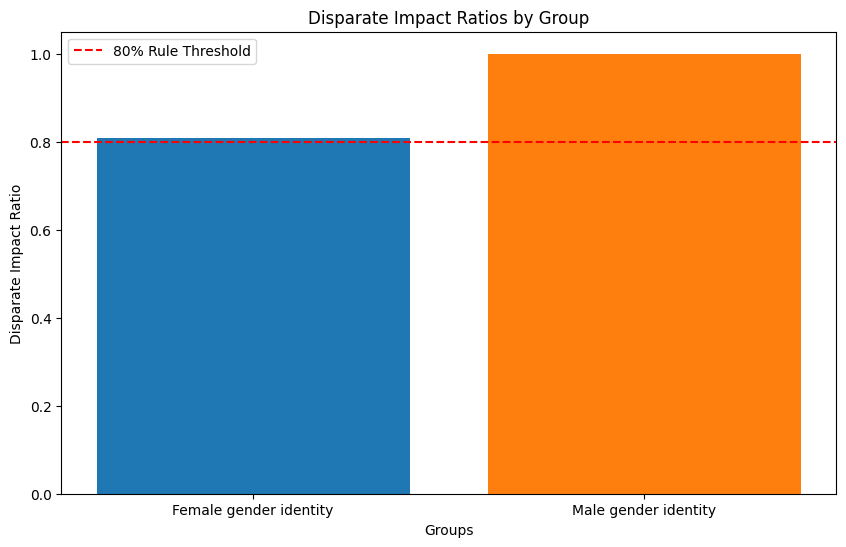

---GENDER---
Chi-Square Statistic: 5.418380185754558, p-value: 0.019925837561293427
Disparate Impact Ratio for Group Female gender identity: 0.8089239641827287
Disparate Impact Ratio for Group Male gender identity: 1.0




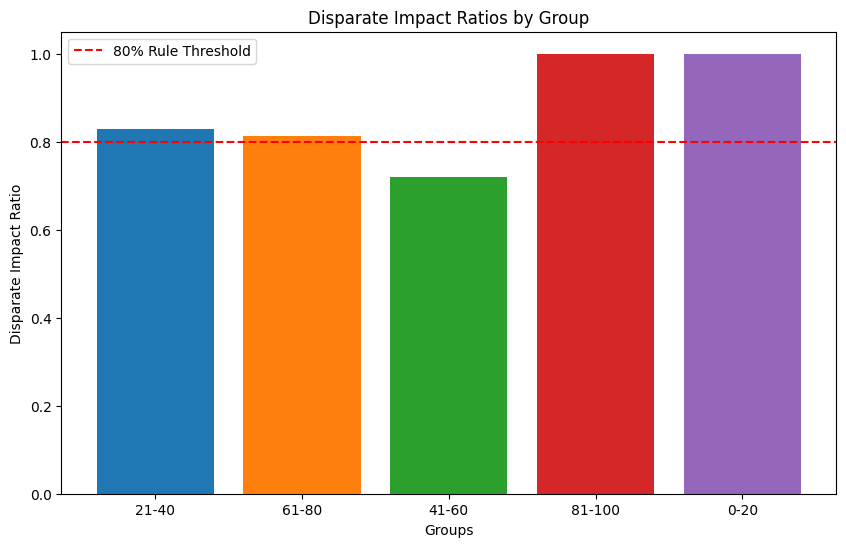

---AGE---
Chi-Square Statistic: 65.52636445401353, p-value: 1.9933066790281102e-13
Disparate Impact Ratio for Group 21-40: 0.8293650793650794
Disparate Impact Ratio for Group 61-80: 0.8140703517587939
Disparate Impact Ratio for Group 41-60: 0.7198697068403909
Disparate Impact Ratio for Group 81-100: 1.0
Disparate Impact Ratio for Group 0-20: 1.0



In [135]:
_, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='gender')
print(print_str)
print()

_, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='age')
print(print_str)

## Just Visualization into lower dimension no classifier

### PCA

In [184]:
target_diagnosis = 'airway_stenosis' #airway_stenosis
#target_diagnosis = 'airway_stenosis'

full_dataset = MyAudioDataset(all_identities, dataset, person_session_pairs,diagnosis_column=target_diagnosis)
opensmile_df, feature_columns, label_columns = create_open_smile_df(full_dataset, include_GAS=False,
                                                                    diagnosis_column=target_diagnosis)

# Perform PCA
pca = PCA(n_components=3)
scalar = StandardScaler()
scaled_features = scalar.fit_transform(opensmile_df[feature_columns])

pca_result = pca.fit_transform(scaled_features)

#prepare the data for plotting 2D scatter plot of PCA features
pca_df = pd.DataFrame(pca_result[:,:2], columns=['PC1', 'PC2'])
#pca_df = pd.concat([pca_df, opensmile_df[['age', 'GENDER_org', 'SITE_org']].reset_index(drop=True)], axis=1)
pca_df = pd.concat([pca_df, opensmile_df[label_columns].reset_index(drop=True)], axis=1)

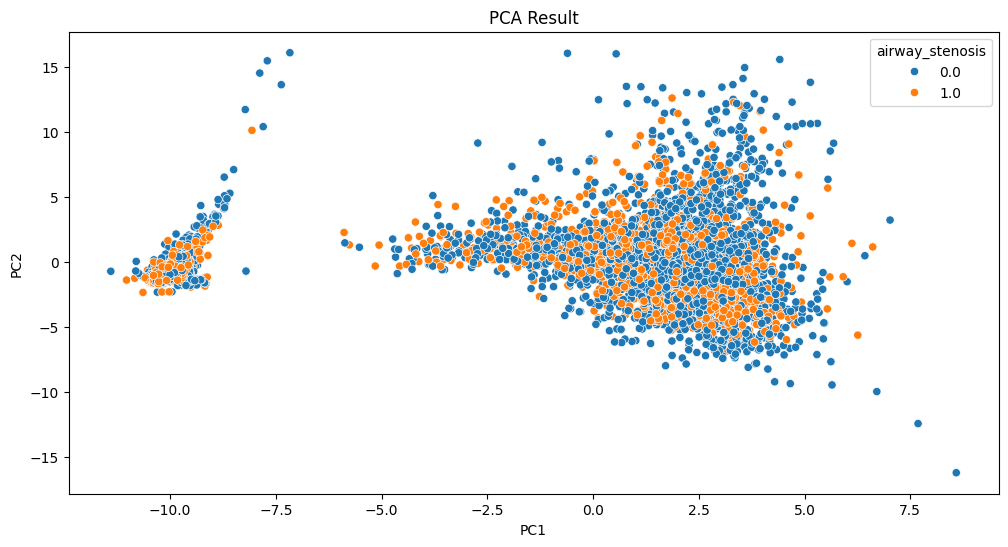

In [137]:
plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue=target_diagnosis, data=pca_df)
plt.title('PCA Result')
plt.show()

#### PCA 2D colored by gender

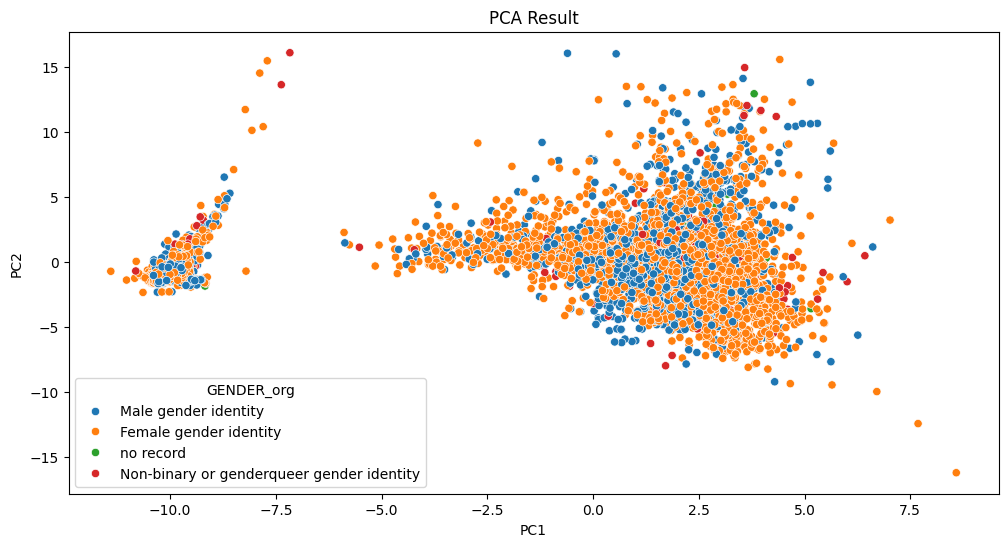

In [138]:
plt.figure(figsize=(12, 6))
#plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='GENDER_org', data=pca_df)
plt.title('PCA Result')
plt.show()

##### PCA 2D scatter plot colored by age

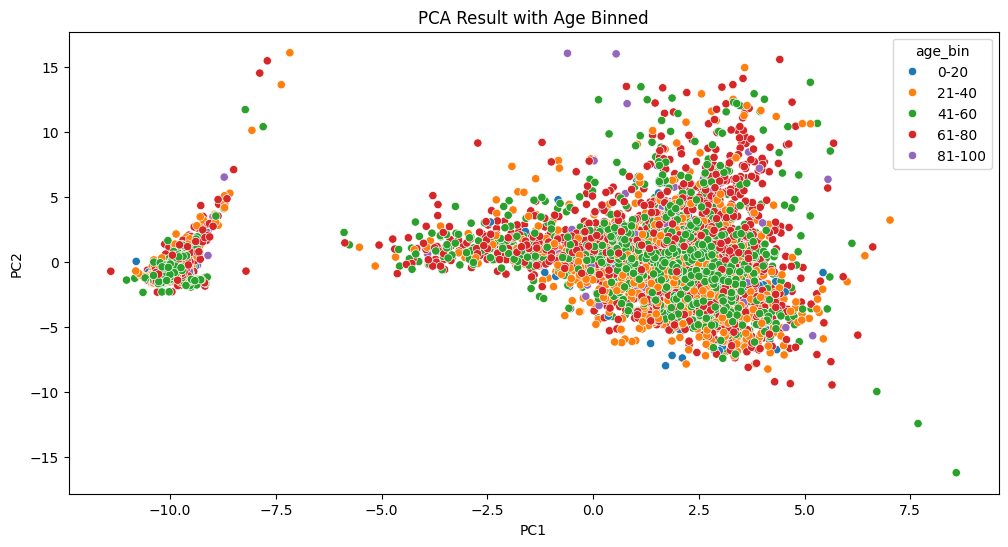

In [139]:
# Define age bins
bins = [0, 20, 40, 60, 80, 100]  # Define bins for age ranges
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']  # Define bin labels
pca_df['age_bin'] = pd.cut(pca_df['age'], bins=bins, labels=labels)

# Plot PCA result with discrete age bins
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='age_bin', data=pca_df)
plt.title('PCA Result with Age Binned')
plt.show()

# K-means clustering PCA

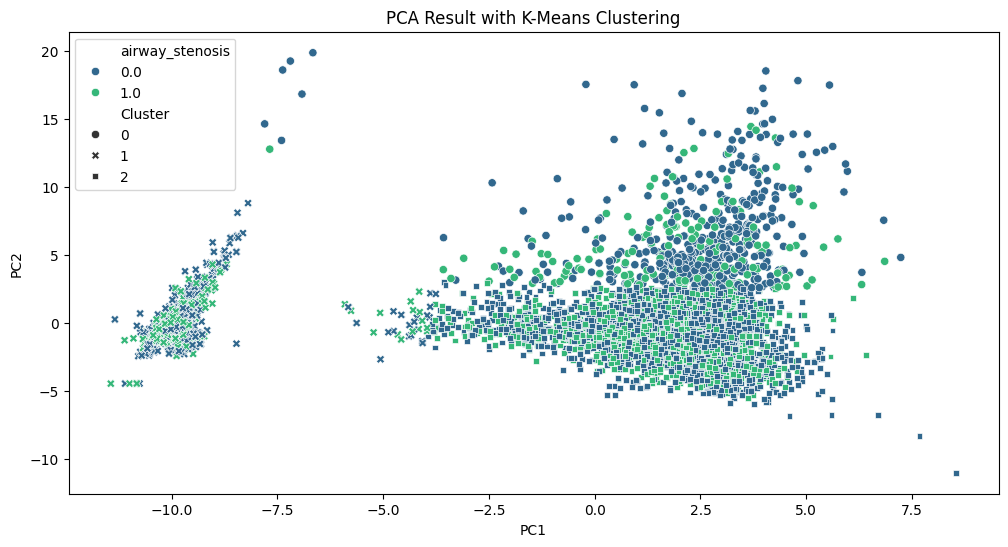

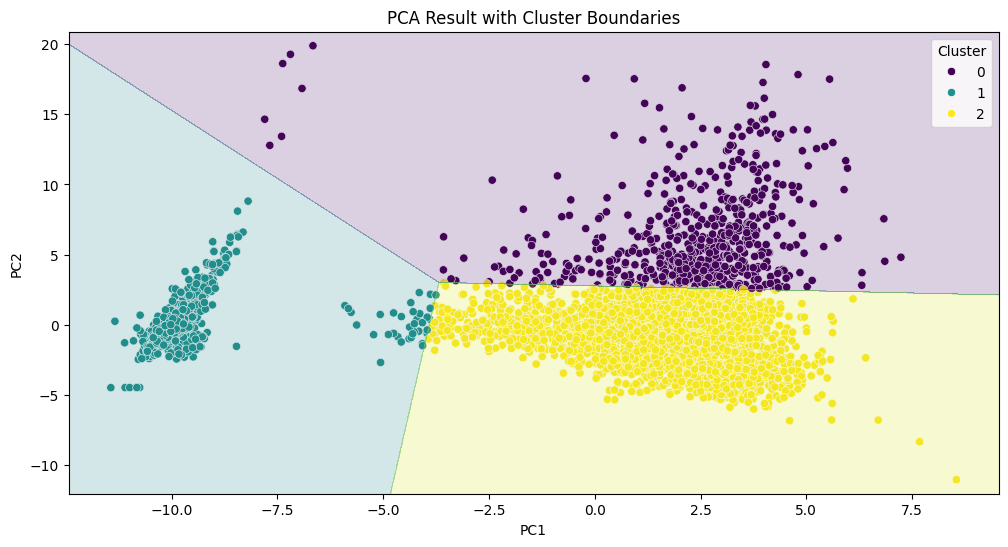

In [159]:
from sklearn.cluster import KMeans

target_diagnosis = 'airway_stenosis' # airway_stenosis

full_dataset = MyAudioDataset(all_identities, dataset, person_session_pairs, diagnosis_column=target_diagnosis)
opensmile_df, feature_columns, label_columns = create_open_smile_df(full_dataset, include_GAS=False, diagnosis_column=target_diagnosis)

# Perform PCA
pca = PCA(n_components=3)
scalar = StandardScaler()
scaled_features = scalar.fit_transform(opensmile_df[feature_columns])

pca_result = pca.fit_transform(scaled_features)

# Ensure PCA result is of type float64
pca_result = pca_result.astype(np.float64)

# Prepare the data for plotting 2D scatter plot of PCA features
pca_df = pd.DataFrame(pca_result[:, :2], columns=['PC1', 'PC2'])
pca_df = pd.concat([pca_df, opensmile_df[label_columns].reset_index(drop=True)], axis=1)

# Perform k-means clustering on the PCA results
kmeans = KMeans(n_clusters=3)  # You can choose the number of clusters
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# Plot PCA results with k-means clustering and target diagnosis
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue=target_diagnosis, style='Cluster', data=pca_df, palette='viridis')
plt.title('PCA Result with K-Means Clustering')
plt.show()

# Plot PCA results with cluster boundaries
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', legend='full')
plt.title('PCA Result with Cluster Boundaries')

# Plot cluster boundaries
x_min, x_max = pca_df['PC1'].min() - 1, pca_df['PC1'].max() + 1
y_min, y_max = pca_df['PC2'].min() - 1, pca_df['PC2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
grid_points = np.c_[xx.ravel(), yy.ravel()].astype(np.float64)
Z = kmeans.predict(grid_points)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')

plt.show()

#### t-SNE

In [142]:
# Perform t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(scaled_features)

#prepare t-SNE result for 2D scatter plot
tsne_df = pd.DataFrame(tsne_result[:,:2], columns=['TSNE1', 'TSNE2'])
tsne_df = pd.concat([tsne_df, opensmile_df[['age', 'GENDER_org']].reset_index(drop=True)], axis=1)

##### t-SNE 2D scatter plot colored by gender

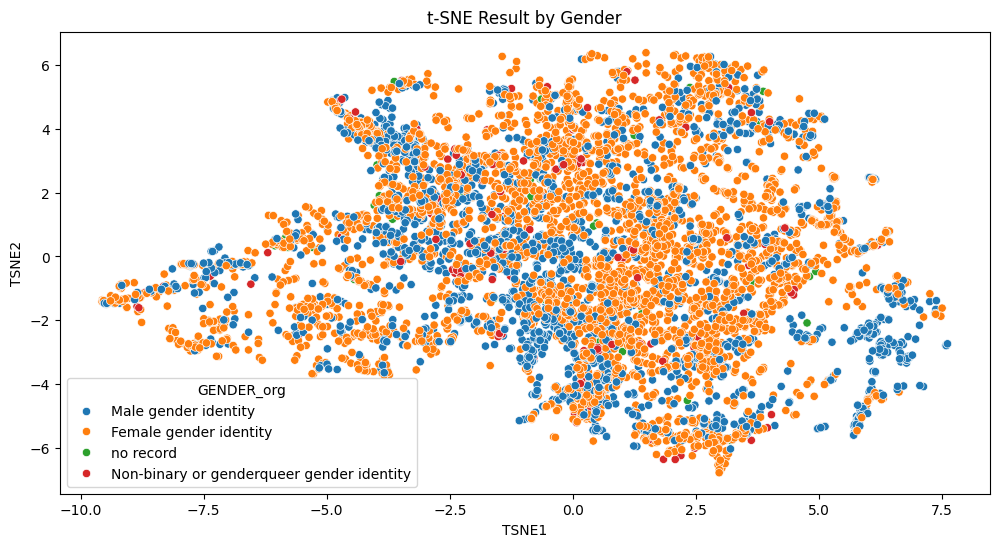

In [143]:
# Plot t-SNE result
#plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='GENDER_org', data=tsne_df)
plt.title('t-SNE Result by Gender')
plt.show()

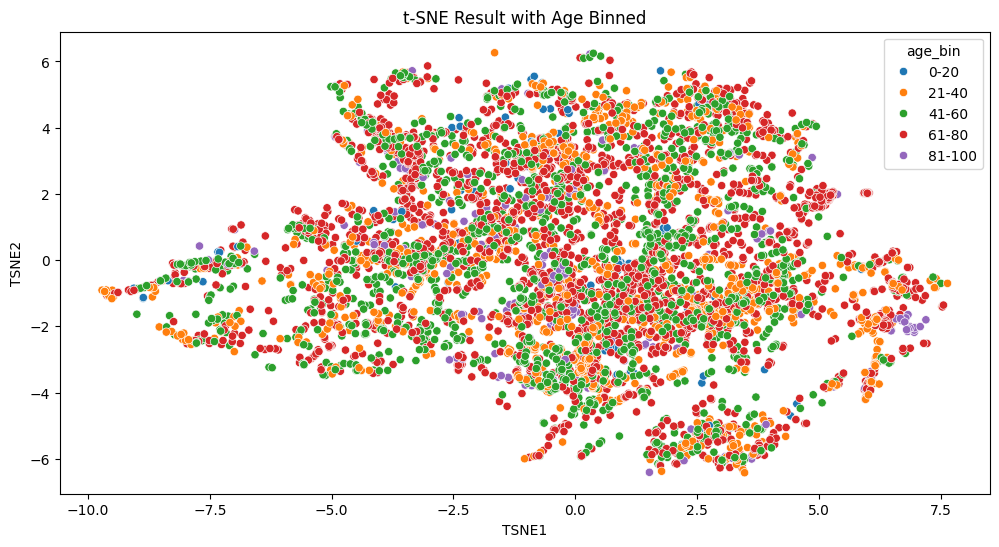

In [32]:
# Define age bins
bins = [0, 20, 40, 60, 80, 100]  # Define bins for age ranges
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']  # Define bin labels
tsne_df['age_bin'] = pd.cut(tsne_df['age'], bins=bins, labels=labels)

# Plot PCA result with discrete age bins
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='age_bin', data=tsne_df,) #coolwarm, plasma, viridis
plt.title('t-SNE Result with Age Binned')
plt.show()

### KMeans clustering for tsne

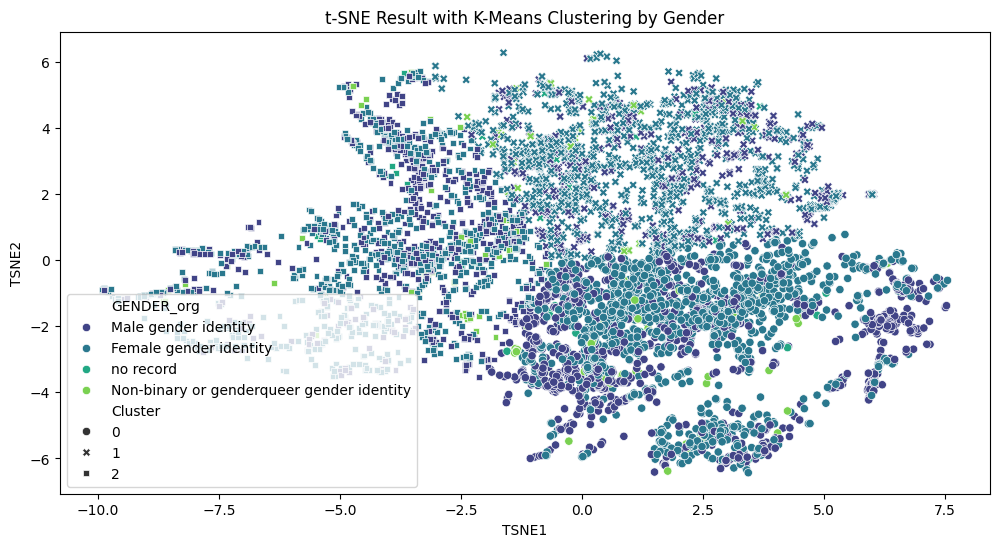

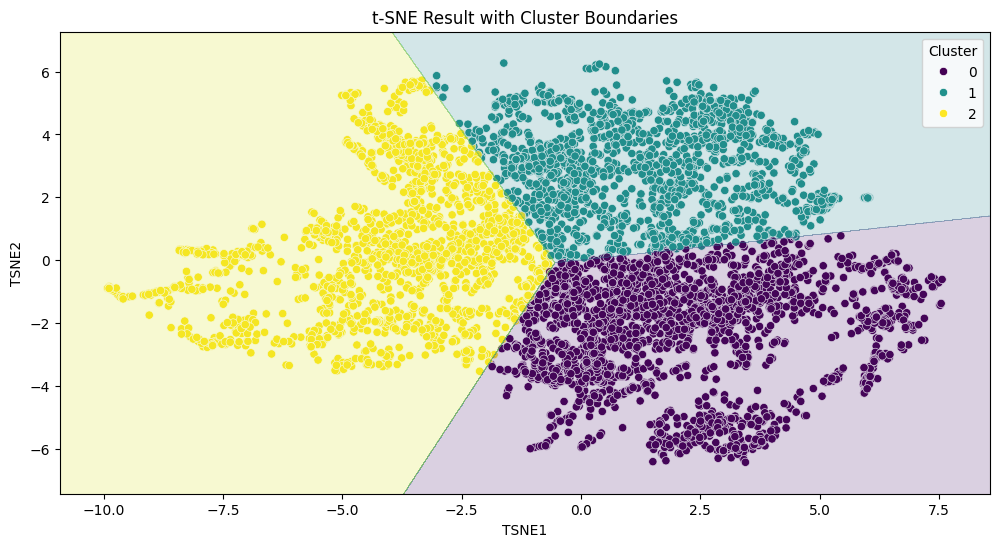

In [185]:
# Your existing code for loading and preprocessing the data
target_diagnosis = 'airway_stenosis' # airway_stenosis

full_dataset = MyAudioDataset(all_identities, dataset, person_session_pairs, diagnosis_column=target_diagnosis)
opensmile_df, feature_columns, label_columns = create_open_smile_df(full_dataset, include_GAS=False, diagnosis_column=target_diagnosis)

# Perform scaling
scalar = StandardScaler()

scaled_features = opensmile_df[feature_columns]   # dropping the site
scaled_features = scaled_features[:-1]

scaled_features = scalar.fit_transform(opensmile_df[feature_columns])

# Perform t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(scaled_features)

# Ensure t-SNE result is of type float64
tsne_result = tsne_result.astype(np.float64)

# Prepare t-SNE result for 2D scatter plot
tsne_df = pd.DataFrame(tsne_result[:, :2], columns=['TSNE1', 'TSNE2'])
tsne_df = pd.concat([tsne_df, opensmile_df[['age', 'GENDER_org', 'SITE_org']].reset_index(drop=True)], axis=1)

# Perform k-means clustering on the t-SNE results
kmeans = KMeans(n_clusters=3)  # You can choose the number of clusters
tsne_df['Cluster'] = kmeans.fit_predict(tsne_df[['TSNE1', 'TSNE2']])

# Plot t-SNE results with k-means clustering and GENDER_org
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='GENDER_org', style='Cluster', data=tsne_df, palette='viridis')
plt.title('t-SNE Result with K-Means Clustering by Gender')
plt.show()

# Plot t-SNE results with cluster boundaries
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=tsne_df, palette='viridis', legend='full')
plt.title('t-SNE Result with Cluster Boundaries')

# Plot cluster boundaries
x_min, x_max = tsne_df['TSNE1'].min() - 1, tsne_df['TSNE1'].max() + 1
y_min, y_max = tsne_df['TSNE2'].min() - 1, tsne_df['TSNE2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
grid_points = np.c_[xx.ravel(), yy.ravel()].astype(np.float64)
Z = kmeans.predict(grid_points)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')

plt.show()


#### Scree plot PCA

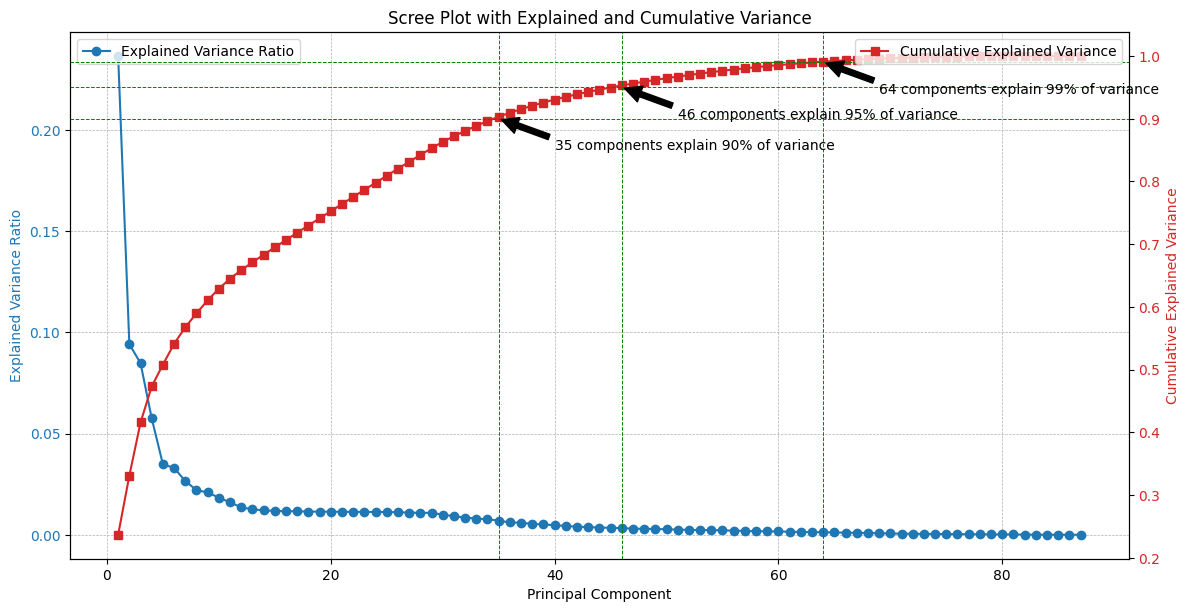

In [186]:
# Perform PCA
pca_full = PCA(n_components=87)
pca_result = pca_full.fit_transform(scaled_features)

#prepare the data for plotting 2D scatter plot of PCA features
#pca_df = pd.DataFrame(pca_result)
#pca_df = pd.concat([pca_df, opensmile_df[['age', 'gender', 'site']].reset_index(drop=True)], axis=1)

variance_ratio= pca_full.explained_variance_ratio_

# Prepare data for plotting
x = np.arange(1, len(variance_ratio) + 1)
y = variance_ratio

# Cumulative explained variance
cumulative_variance = np.cumsum(variance_ratio)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot explained variance
color = 'tab:blue'
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio', color=color)
ax1.plot(x, y, 'o-', color=color, label='Explained Variance Ratio')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot cumulative explained variance
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Cumulative Explained Variance', color=color)
ax2.plot(x, cumulative_variance, 's-', color=color, label='Cumulative Explained Variance')
ax2.tick_params(axis='y', labelcolor=color)

# Adding legend
fig.tight_layout()  # To ensure the right y-label is not slightly clipped
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adding titles and labels
plt.title('Scree Plot with Explained and Cumulative Variance')
plt.xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax2.set_ylabel('Cumulative Explained Variance')

# Annotate the point where 95% of variance is explained
# Annotate the point where 90%, 95%, and 99% of variance is explained
thresholds = [0.90, 0.95, 0.99]
for threshold in thresholds:
    num_components_to_threshold = np.argmax(cumulative_variance >= threshold) + 1
    ax2.axhline(y=threshold, color='g', linestyle='--', linewidth=0.7)
    ax2.axvline(x=num_components_to_threshold, color='g', linestyle='--', linewidth=0.7)
    ax2.annotate(f'{num_components_to_threshold} components explain {threshold * 100:.0f}% of variance',
                 xy=(num_components_to_threshold, threshold), xytext=(num_components_to_threshold + 5, threshold - 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05))


# Show the plot
plt.show()

In [85]:
def calc_min_principle_comp_required(variance_ratio, variance_ratio_threshold):
  
  maintained_variance_ratio = 0.0
  n = 1

  while maintained_variance_ratio < variance_ratio_threshold:

    maintained_variance_ratio = sum(variance_ratio[:n])
    n+=1

  return n-1

In [71]:
principal_component_count_90 = calc_min_principle_comp_required(variance_ratio, 0.90)

print(principal_component_count_90)

35


In [72]:
principal_component_count_95 = calc_min_principle_comp_required(variance_ratio, 0.95)

print(principal_component_count_95)

46


In [73]:
principal_component_count_99 = calc_min_principle_comp_required(variance_ratio, 0.99)

print(principal_component_count_99)

64


#### Scree plot t-SNE

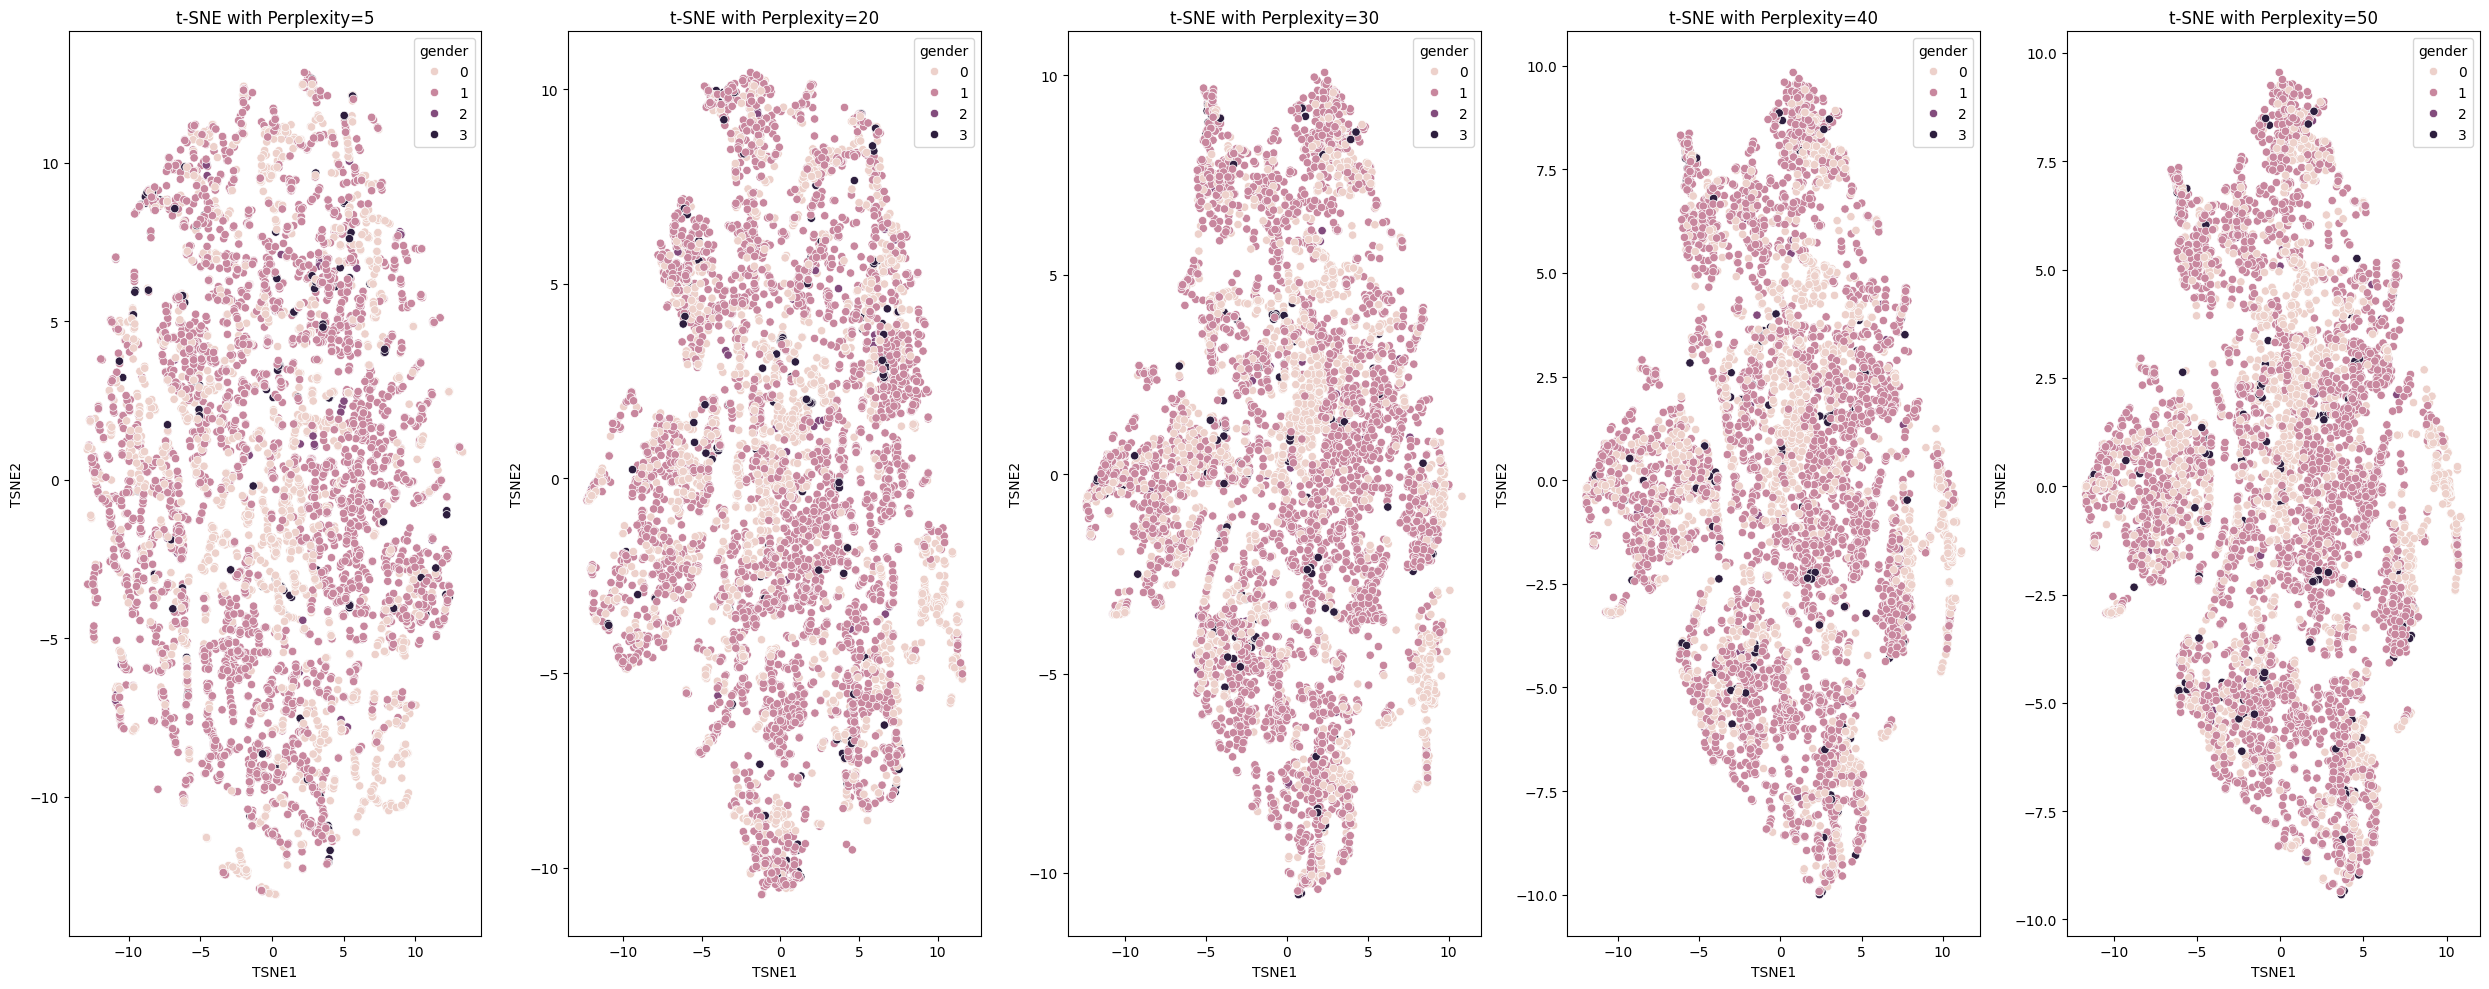

In [187]:
'''
## Acknowledgements
Special thanks to ChatGPT for providing code snippets and guidance for the implementation of various techniques in this project. 
[OpenAI’s ChatGPT](https://www.openai.com/chatgpt) was instrumental in generating code and answering questions about data analysis and 
visualization.
'''

# Define perplexity values
perplexities = [5, 20, 30, 40, 50]

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 10))

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300)
    tsne_result = tsne.fit_transform(scaled_features)
    
    # Create DataFrame for plotting
    #tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
    tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
    tsne_df = pd.concat([tsne_df, opensmile_df[['age', 'gender']].reset_index(drop=True)], axis=1)
    tsne_df['perplexity'] = perplexity
    
    # Plot
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='gender', data=tsne_df, ax=axes[i])
    #sns.scatterplot(x='TSNE1', y='TSNE2', data=tsne_df, ax=axes[i])
    axes[i].set_title(f't-SNE with Perplexity={perplexity}')
    axes[i].set_xlabel('TSNE1')
    axes[i].set_ylabel('TSNE2')

plt.tight_layout()
plt.show()
